<a href="https://colab.research.google.com/github/morshedonil/CalculatorApp/blob/main/Rice_fruit_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install rembg onnxruntime tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 336.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.svm import SVC
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import random
import math
import time
from rembg import remove
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, callbacks

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moltean/fruits")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fruits


# Formatting data for SVM & KNN

In [ ]:
def process_train_dataset(base_path):
    """
    Process a dataset of fruit images, creating flattened pixel arrays and labels.
    Only the first 100 valid images from each folder are processed.

    Args:
        base_path (str): Path to the base directory containing fruit folders.

    Returns:
        list: List of [flattened_image_array, label] pairs.
    """
    # Lists to store processed data
    data = []

    # Supported image extensions
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

    # Iterate through each folder (representing a fruit type)
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)

        if not os.path.isdir(folder_path):
            continue  # Skip non-folder files

        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]
        image_files = image_files[:250]  # Take the first 100 images only

        for image_filename in image_files:
            image_path = os.path.join(folder_path, image_filename)

            try:
                with Image.open(image_path) as img:
                    # Resize to consistent size (60x60)
                    img_resized = img.resize((60, 60))

                    # Convert to RGB if not already
                    img_rgb = img_resized.convert('RGB')

                    # Flatten the image
                    img_array = np.array(img_rgb).flatten()

                    # Append image array and label (folder name)
                    data.append([img_array, folder_name])

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    return data


In [ ]:
def process_test_dataset(base_path):
    """
    Process a dataset of fruit images, creating flattened pixel arrays and labels.
    Only the first 100 valid images from each folder are processed.

    Args:
        base_path (str): Path to the base directory containing fruit folders.

    Returns:
        list: List of [flattened_image_array, label] pairs.
    """
    # Lists to store processed data
    data = []

    # Supported image extensions
    valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

    # Iterate through each folder (representing a fruit type)
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)

        if not os.path.isdir(folder_path):
            continue  # Skip non-folder files

        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(valid_extensions)]
        image_files = image_files[:100]  # Take the first 100 images only

        for image_filename in image_files:
            image_path = os.path.join(folder_path, image_filename)

            try:
                with Image.open(image_path) as img:
                    # Resize to consistent size (60x60)
                    img_resized = img.resize((60, 60))

                    # Convert to RGB if not already
                    img_rgb = img_resized.convert('RGB')

                    # Flatten the image
                    img_array = np.array(img_rgb).flatten()

                    # Append image array and label (folder name)
                    data.append([img_array, folder_name])

            except Exception as e:
                print(f"Error processing {image_path}: {e}")

    return data

In [ ]:
# Example usage
train_directory = '/content/gdrive/MyDrive/fruit_360/train'
train_data = process_train_dataset(train_directory)

In [ ]:
test_directory = '/content/gdrive/MyDrive/fruit_360/test'
test_data = process_test_dataset(test_directory)

In [ ]:
print(len(train_data))
print(len(test_data))

5750
2300


In [ ]:
train_features = []
train_labels = []

random.shuffle(train_data)

for feature, label in train_data:
  train_features.append(feature)
  train_labels.append(label)

In [ ]:
test_features = []
test_labels = []

random.shuffle(test_data)

for feature, label in test_data:
  test_features.append(feature)
  test_labels.append(label)

# Formatting data for ResNet

In [ ]:
# Load training dataset without preprocessing
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset='training',
    batch_size=32,
    image_size=(100, 100),
    seed=123,
    shuffle=True,
)

# Load validation dataset without preprocessing
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    validation_split=0.2,
    subset='validation',
    batch_size=32,
    image_size=(100, 100),
    seed=42,
)

Found 12431 files belonging to 23 classes.
Using 9945 files for training.
Found 12431 files belonging to 23 classes.
Using 2486 files for validation.


In [ ]:
# for faster training which takes less time and less memory for training

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Data Augmentation

# Augmentation for training dataset
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

# Background removal

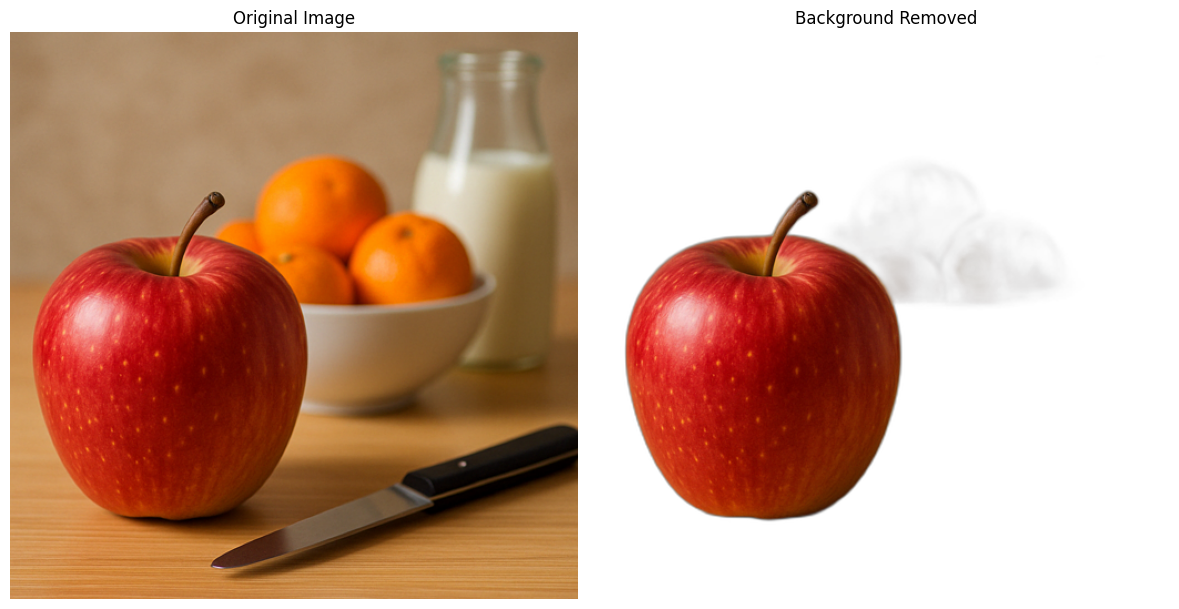

In [ ]:
# === Load Image ===
input_path = '/content/gdrive/MyDrive/multi_obj.png'
input_image = Image.open(input_path).convert("RGBA")  # Ensure alpha support

# === Resize Input for Display (optional, doesn't affect removal) ===
resized_input = input_image.resize(
    (input_image.width // 2, input_image.height // 2)
)

# === Remove Background ===
output_image = remove(input_image)

# === Resize Output for Display ===
resized_output = output_image.resize(
    (output_image.width // 2, output_image.height // 2)
)

# === Save Transparent PNG Output ===
resized_output.save('/content/gdrive/MyDrive/fruit_360/multi_obj_output.png', format='PNG')

# === Display Side-by-Side ===
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(resized_input)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(resized_output)
plt.title("Background Removed")
plt.axis("off")

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/fruit_360/multi_obj_output_comparison.png', bbox_inches='tight', dpi=400)

plt.show()

# SVM

In [ ]:
start_time_svm = time.time()
model_svm = SVC(C=1.0, kernel='linear', gamma='scale', random_state=42)
model_svm.fit(train_features, train_labels)
svm_train_time = time.time() - start_time_svm

In [ ]:
y_pred = model_svm.predict(train_features)
print(metrics.accuracy_score(train_labels, y_pred))

1.0


In [ ]:
y_pred_test = model_svm.predict(test_features)
svm_accuracy = metrics.accuracy_score(test_labels, y_pred_test)
print(svm_accuracy)

0.9860869565217392


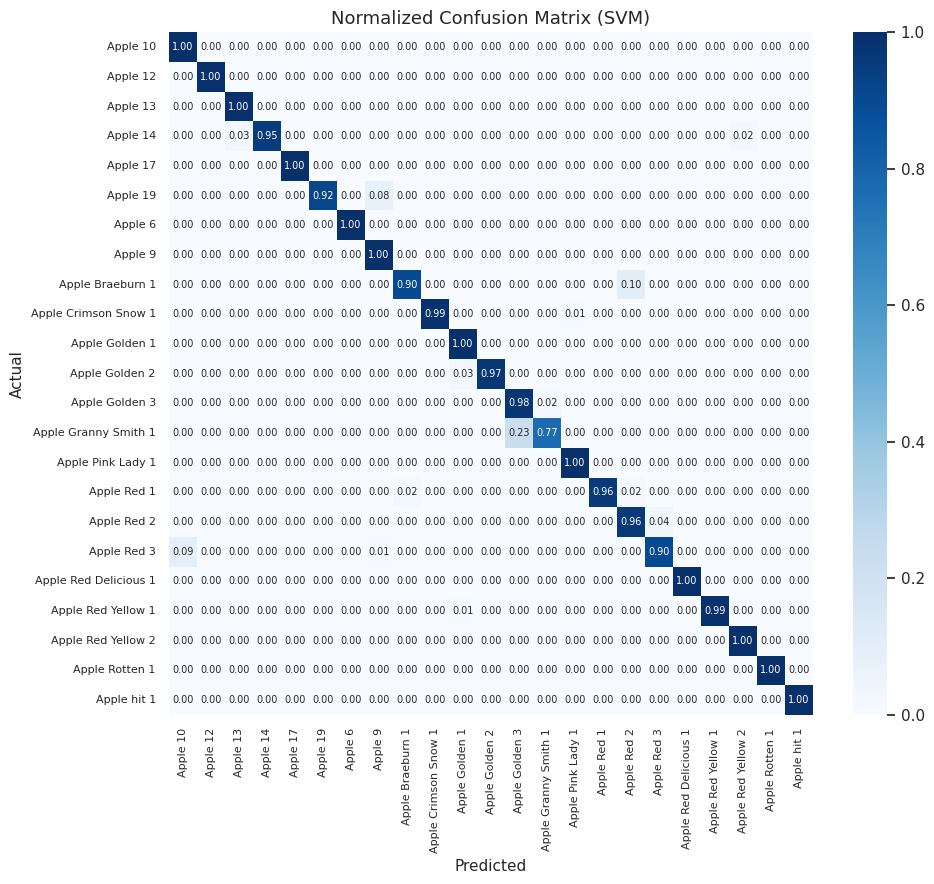

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Compute normalized confusion matrix
cm_svm = confusion_matrix(test_labels, y_pred_test, normalize='true')

# Smaller figure size and slightly reduced font
plt.figure(figsize=(10, 9))  # reduced from (14, 12)
sns.heatmap(cm_svm,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels),
            annot_kws={"size": 7})  # smaller annotation font

plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)
plt.title("Normalized Confusion Matrix (SVM)", fontsize=13)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/confusion_matrix_svm.png', bbox_inches='tight', dpi=300)
plt.show()

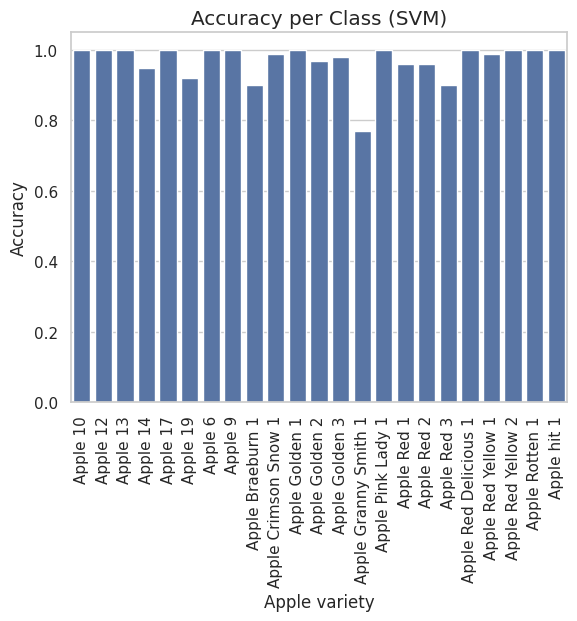

In [ ]:
class_accuracies_svm = cm_svm.diagonal()
class_accuracies_svm

sns.barplot(x=np.unique(test_labels), y=class_accuracies_svm)
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.xlabel('Apple variety')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Accuracy per Class (SVM)')
plt.savefig('/content/gdrive/MyDrive/accuracy_per_class_svm.png', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred_test))

                       precision    recall  f1-score   support

             Apple 10       0.92      1.00      0.96       100
             Apple 12       1.00      1.00      1.00       100
             Apple 13       0.97      1.00      0.99       100
             Apple 14       1.00      0.95      0.97       100
             Apple 17       1.00      1.00      1.00       100
             Apple 19       1.00      0.92      0.96       100
              Apple 6       1.00      1.00      1.00       100
              Apple 9       0.92      1.00      0.96       100
     Apple Braeburn 1       0.98      0.90      0.94       100
 Apple Crimson Snow 1       1.00      0.99      0.99       100
       Apple Golden 1       0.96      1.00      0.98       100
       Apple Golden 2       1.00      0.97      0.98       100
       Apple Golden 3       0.81      0.98      0.89       100
 Apple Granny Smith 1       0.97      0.77      0.86       100
    Apple Pink Lady 1       0.99      1.00      1.00  

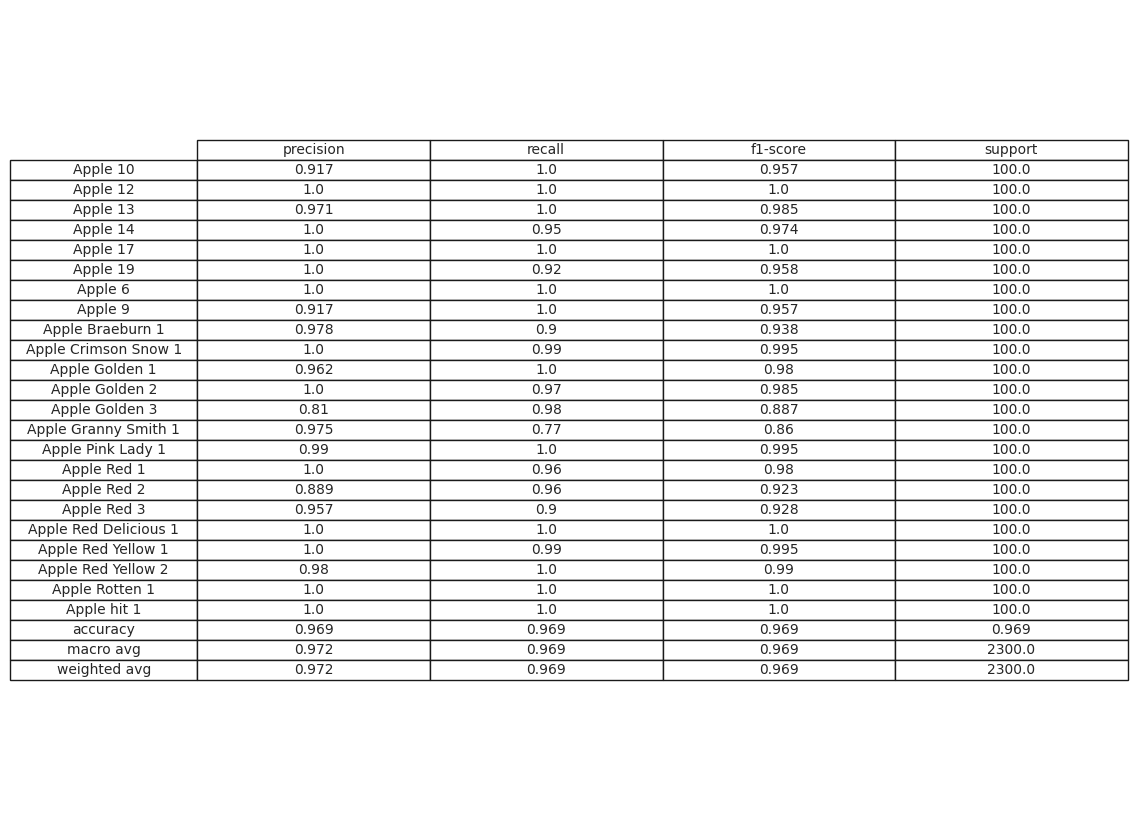

In [ ]:
import matplotlib.pyplot as plt

# Setup figure and axis
fig, ax = plt.subplots(figsize=(12, len(svm_report_df)*0.4))  # Dynamic height
ax.axis('off')

# Create a table
table = ax.table(cellText=svm_report_df.values,
                 colLabels=svm_report_df.columns,
                 rowLabels=svm_report_df.index,
                 cellLoc='center',
                 rowLoc='center',
                 loc='center')

# Style
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.2)

# Save to Google Drive
plt.savefig('/content/gdrive/MyDrive/svm_classification_report.png', bbox_inches='tight', dpi=300)
plt.show()

# KNN

In [ ]:
start_time_knn = time.time()
model_knn = KNeighborsClassifier(n_neighbors=3, algorithm='auto', metric='euclidean', weights='uniform')
model_knn.fit(train_features, train_labels)
knn_train_time = time.time() - start_time_knn

In [ ]:
y_pred_knn = model_knn.predict(train_features)
print(metrics.accuracy_score(train_labels, y_pred_knn))

0.9994782608695653


In [ ]:
y_pred_knn_test = model_knn.predict(test_features)
knn_accuracy = metrics.accuracy_score(test_labels, y_pred_knn_test)
print(knn_accuracy)

0.9152173913043479


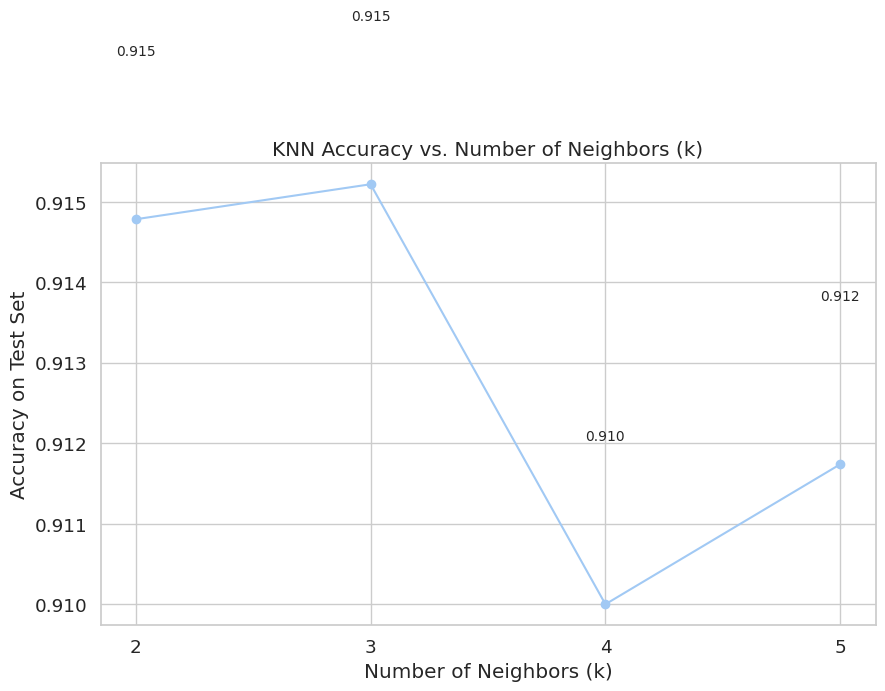

In [ ]:
# Define relevant k values for apple classification
k_values = list(range(2, 6, 1))  #32
accuracies = []

# Fit KNN for each k and record accuracy
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(train_features, train_labels)
    y_pred = knn.predict(test_features)
    acc = accuracy_score(test_labels, y_pred)
    accuracies.append(acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-')
plt.title('KNN Accuracy vs. Number of Neighbors (k)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy on Test Set')
plt.xticks(k_values)
plt.grid(True)

# Annotate each point with its accuracy value
for i, acc in enumerate(accuracies):
    plt.text(k_values[i], accuracies[i] + 0.002, f"{acc:.3f}", ha='center', va='bottom', fontsize=10)

plt.savefig('/content/gdrive/MyDrive/knn_accuracy_vs_k.png', bbox_inches='tight')
plt.show()

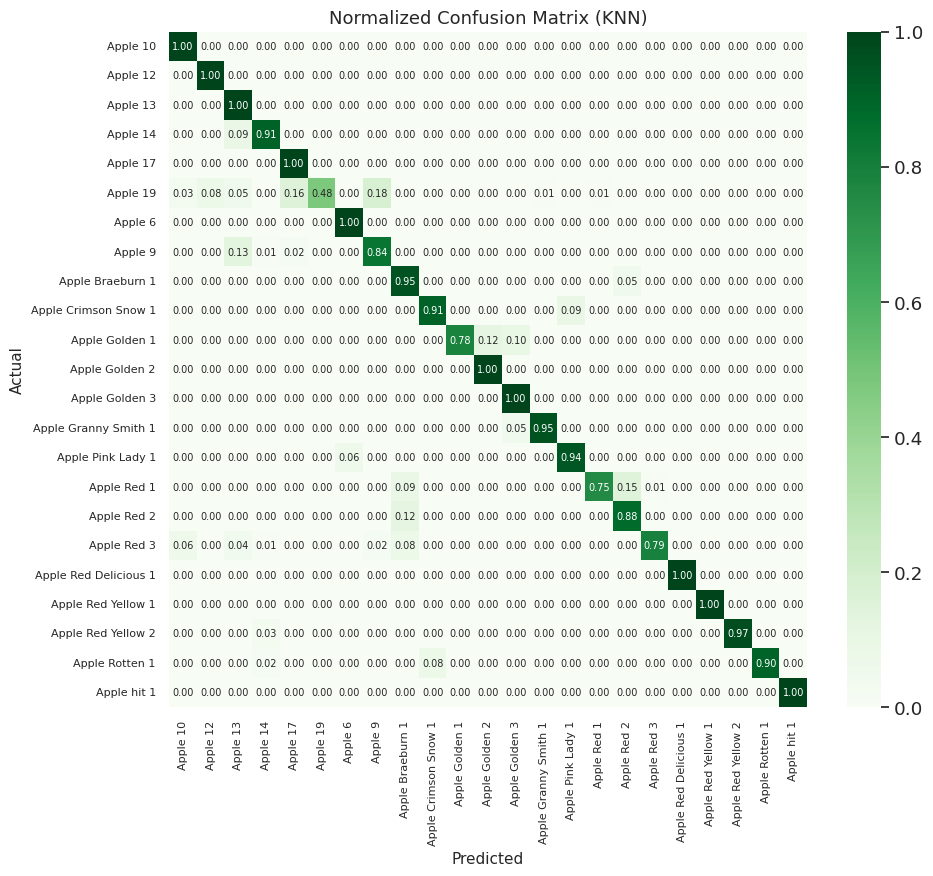

In [ ]:
cm_knn = confusion_matrix(test_labels, y_pred_knn_test, normalize='true')

plt.figure(figsize=(10, 9))
sns.heatmap(cm_knn,
            annot=True,
            fmt=".2f",
            cmap="Greens",
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels),
            annot_kws={"size": 7})

plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)
plt.title("Normalized Confusion Matrix (KNN)", fontsize=13)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/confusion_matrix_knn.png', bbox_inches='tight', dpi=300)
plt.show()


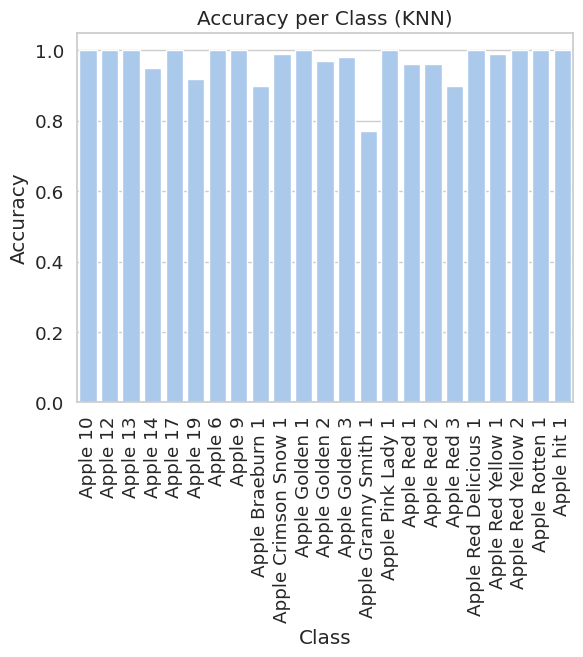

In [ ]:
class_accuracies_knn = cm_knn.diagonal()

sns.barplot(x=np.unique(test_labels), y=class_accuracies_svm)
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.xlabel('Class')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Accuracy per Class (KNN)')
plt.savefig('/content/gdrive/MyDrive/accuracy_per_class_knn.png', bbox_inches='tight')
plt.show()

In [ ]:
print(classification_report(test_labels, y_pred_knn_test))

                       precision    recall  f1-score   support

             Apple 10       0.92      1.00      0.96       100
             Apple 12       0.93      1.00      0.96       100
             Apple 13       0.76      1.00      0.87       100
             Apple 14       0.93      0.91      0.92       100
             Apple 17       0.85      1.00      0.92       100
             Apple 19       1.00      0.48      0.65       100
              Apple 6       0.94      1.00      0.97       100
              Apple 9       0.81      0.84      0.82       100
     Apple Braeburn 1       0.77      0.95      0.85       100
 Apple Crimson Snow 1       0.92      0.91      0.91       100
       Apple Golden 1       1.00      0.78      0.88       100
       Apple Golden 2       0.89      1.00      0.94       100
       Apple Golden 3       0.87      1.00      0.93       100
 Apple Granny Smith 1       0.99      0.95      0.97       100
    Apple Pink Lady 1       0.91      0.94      0.93  

In [ ]:
fig, ax = plt.subplots(figsize=(12, len(knn_df)*0.4))
ax.axis('off')

table = ax.table(cellText=knn_df.values,
                 colLabels=knn_df.columns,
                 rowLabels=knn_df.index,
                 cellLoc='center',
                 rowLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.2)

plt.savefig('/content/gdrive/MyDrive/knn_classification_report.png', bbox_inches='tight', dpi=300)
plt.show()


NameError: name 'plt' is not defined

# Random Forest

In [ ]:
start_time_rf = time.time()
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(train_features, train_labels)
rf_train_time = time.time() - start_time_rf

In [ ]:
y_pred = model_rf.predict(train_features)
print(metrics.accuracy_score(train_labels, y_pred))

1.0


In [ ]:
y_pred_test_rf = model_rf.predict(test_features)
rf_accuracy = metrics.accuracy_score(test_labels, y_pred_test)
print(rf_accuracy)

0.9691304347826087


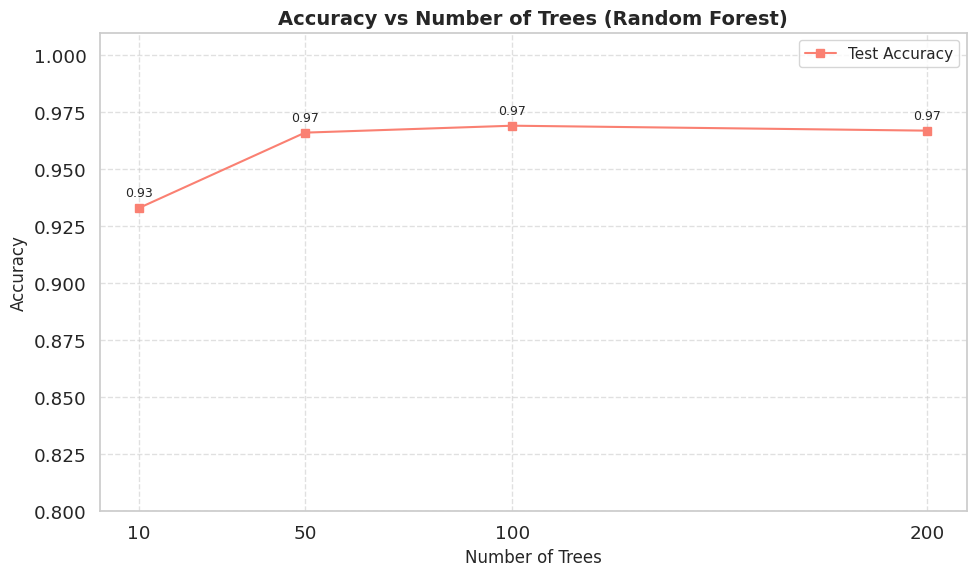

In [ ]:
# ===========================================
# 🔹 4. Accuracy vs Number of Trees
# ===========================================
# Define hyperparameter values (number of trees)
estimators = [10, 50, 100, 200]
train_acc, test_acc = [], []

# Measure accuracy for each number of trees
for n in estimators:
    model = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    model.fit(train_features, train_labels)
    train_acc.append(accuracy_score(train_labels, model.predict(train_features)))
    test_acc.append(accuracy_score(test_labels, model.predict(test_features)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(estimators, test_acc, marker='s', linestyle='-', color='salmon', label='Test Accuracy')

# Add annotations
for i, (x, y) in enumerate(zip(estimators, test_acc)):
    plt.text(x, y + 0.005, f"{y:.2f}", ha='center', fontsize=9)

# Aesthetics
plt.title('Accuracy vs Number of Trees (Random Forest)', fontsize=14, weight='bold')
plt.xlabel('Number of Trees', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)
plt.xticks(estimators)
plt.ylim(0.8, 1.01)  # adjust based on your data
plt.tight_layout()

# Save and show
plt.savefig('/content/gdrive/MyDrive/accuracy_vs_trees.png', bbox_inches='tight')
plt.show()
plt.close()


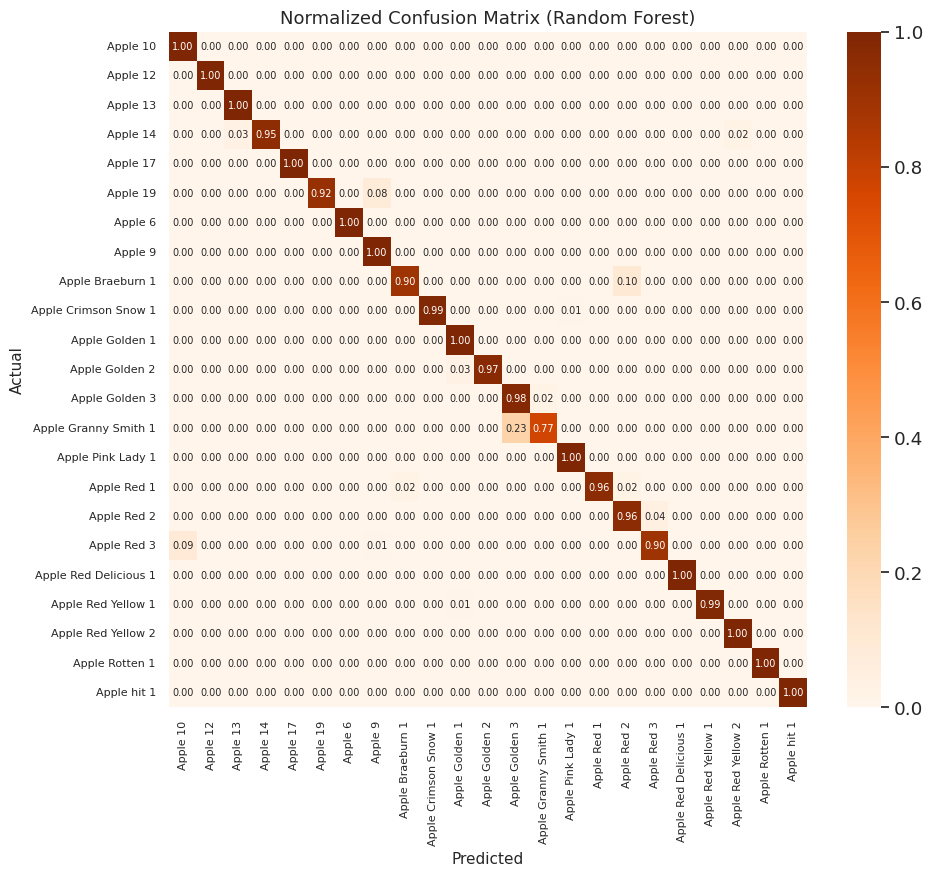

In [ ]:
cm_rf = confusion_matrix(test_labels, y_pred_test_rf, normalize='true')  # Reuse y_pred_test from RF block

plt.figure(figsize=(10, 9))
sns.heatmap(cm_rf,
            annot=True,
            fmt=".2f",
            cmap="Oranges",
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels),
            annot_kws={"size": 7})

plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)
plt.title("Normalized Confusion Matrix (Random Forest)", fontsize=13)

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/confusion_matrix_rf.png', bbox_inches='tight', dpi=300)
plt.show()


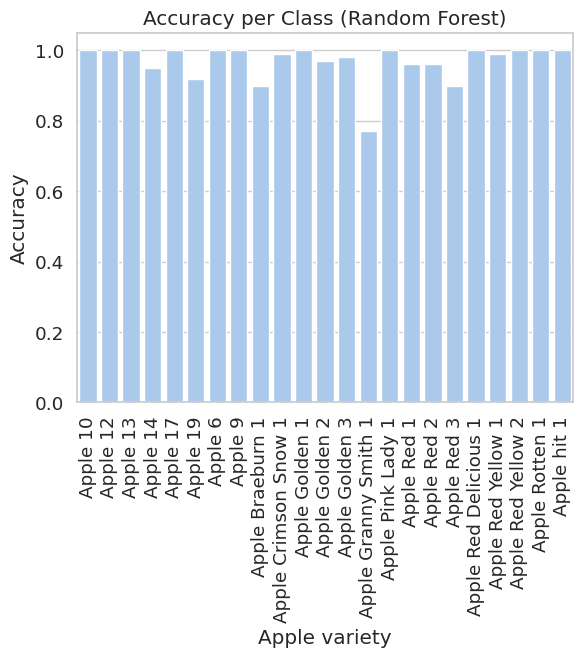

In [ ]:
class_accuracies_rf = cm_rf.diagonal()

sns.barplot(x=np.unique(test_labels), y=class_accuracies_rf)
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.set_palette("pastel")
plt.xlabel('Apple variety')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
plt.title('Accuracy per Class (Random Forest)')
plt.savefig('/content/gdrive/MyDrive/accuracy_per_class_rf.png', bbox_inches='tight')
plt.show()

In [ ]:
print(classification_report(test_labels, y_pred_test_rf))

                       precision    recall  f1-score   support

             Apple 10       0.92      1.00      0.96       100
             Apple 12       1.00      1.00      1.00       100
             Apple 13       0.97      1.00      0.99       100
             Apple 14       1.00      0.95      0.97       100
             Apple 17       1.00      1.00      1.00       100
             Apple 19       1.00      0.92      0.96       100
              Apple 6       1.00      1.00      1.00       100
              Apple 9       0.92      1.00      0.96       100
     Apple Braeburn 1       0.98      0.90      0.94       100
 Apple Crimson Snow 1       1.00      0.99      0.99       100
       Apple Golden 1       0.96      1.00      0.98       100
       Apple Golden 2       1.00      0.97      0.98       100
       Apple Golden 3       0.81      0.98      0.89       100
 Apple Granny Smith 1       0.97      0.77      0.86       100
    Apple Pink Lady 1       0.99      1.00      1.00  

In [ ]:
fig, ax = plt.subplots(figsize=(12, len(rf_df)*0.4))
ax.axis('off')

table = ax.table(cellText=rf_df.values,
                 colLabels=rf_df.columns,
                 rowLabels=rf_df.index,
                 cellLoc='center',
                 rowLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.2)

plt.savefig('/content/gdrive/MyDrive/rf_classification_report.png', bbox_inches='tight', dpi=300)
plt.show()

# ResNet

In [ ]:
# Get the class names from the subdirectories in the training directory
class_names = sorted(os.listdir(train_directory))

# Print the class names and the number of classes
print("Class Names:", class_names)
num_classes = len(class_names)
print("Number of Classes:", num_classes)

Class Names: ['Apple 10', 'Apple 12', 'Apple 13', 'Apple 14', 'Apple 17', 'Apple 19', 'Apple 6', 'Apple 9', 'Apple Braeburn 1', 'Apple Crimson Snow 1', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith 1', 'Apple Pink Lady 1', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious 1', 'Apple Red Yellow 1', 'Apple Red Yellow 2', 'Apple Rotten 1', 'Apple hit 1']
Number of Classes: 23


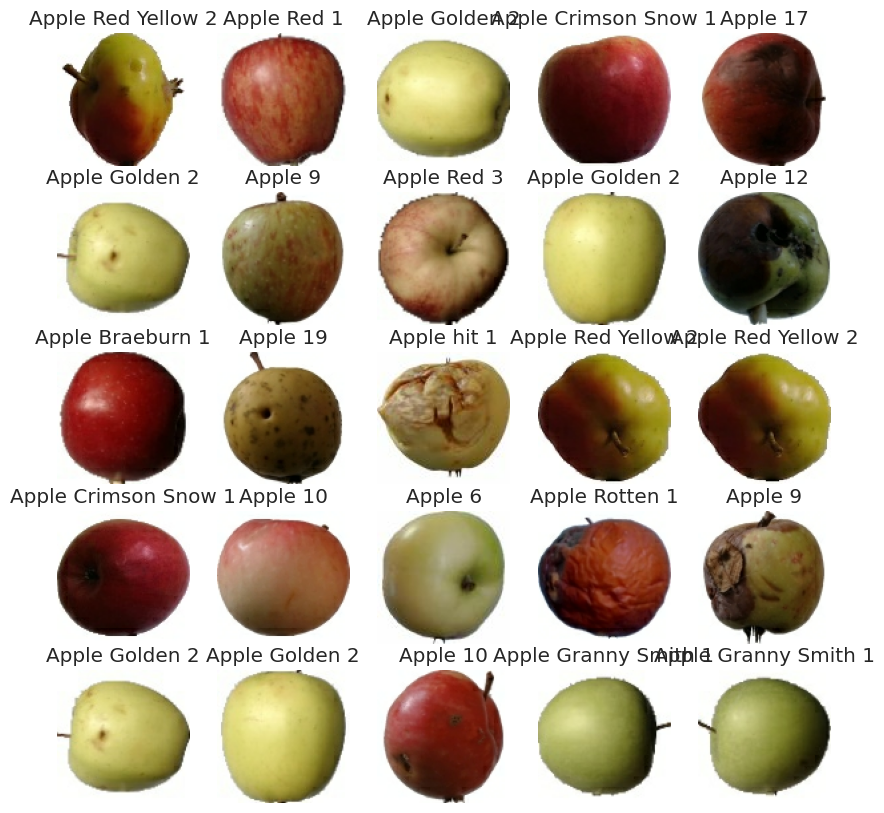

In [ ]:
# Function to display images from a dataset
def show_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take one batch from the dataset
        for i in range(25):  # Display 25 images
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

# Show images from training dataset
show_images(train_ds, class_names)
plt.show()

In [ ]:
#ResNet 50 setup

# Using resNET model of transfer learning for training
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape=(100, 100, 3))

In [ ]:
preprocess_input = tf.keras.applications.resnet.preprocess_input
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(num_classes)

In [ ]:
#Building the Model

inputs = tf.keras.Input(shape=(100, 100, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

resnet_model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

resnet_model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 106, 106,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 50, 50,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 50, 50,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 50, 50,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 52, 52,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 25, 25,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 25, 25,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 25, 25,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 25, 25,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 25, 25,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 25, 25,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 25, 25,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 25, 25,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 25, 25,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 25, 25,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
#Model training-

# Define EarlyStopping callback
early_stopping = callbacks.EarlyStopping(patience=3)

start_time_resnet = time.time()

# Train the model with early stopping
history = resnet_model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[early_stopping]  # Add the EarlyStopping callback to the training process
)

time_resnet = time.time() - start_time_resnet

Epoch 1/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step - accuracy: 0.1836 - loss: 3.2601 - val_accuracy: 0.7397 - val_loss: 1.0562
Epoch 2/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.7126 - loss: 1.0056 - val_accuracy: 0.8854 - val_loss: 0.5586
Epoch 3/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.8562 - loss: 0.5516 - val_accuracy: 0.9381 - val_loss: 0.3625
Epoch 4/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9132 - loss: 0.3879 - val_accuracy: 0.9730 - val_loss: 0.2567
Epoch 5/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9345 - loss: 0.2923 - val_accuracy: 0.9819 - val_loss: 0.1987
Epoch 6/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9575 - loss: 0.2139 - val_accuracy: 0.9887 - val_loss: 0.1549
Epoch 7/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 15s 48ms/step - accuracy: 0.9667 - loss: 0.1727 - val_accuracy: 0.9907 - val_loss: 0.1295
Epoch 8/10
311/311 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.9739 - loss: 0.1490 - 

In [ ]:
resnet_accuracy = resnet_model.evaluate(val_ds)[1]  # Assuming accuracy is the second metric
print(f"ResNet Test Accuracy: {resnet_accuracy:.4f}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.9921 - loss: 0.0821
ResNet Test Accuracy: 0.9940


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━

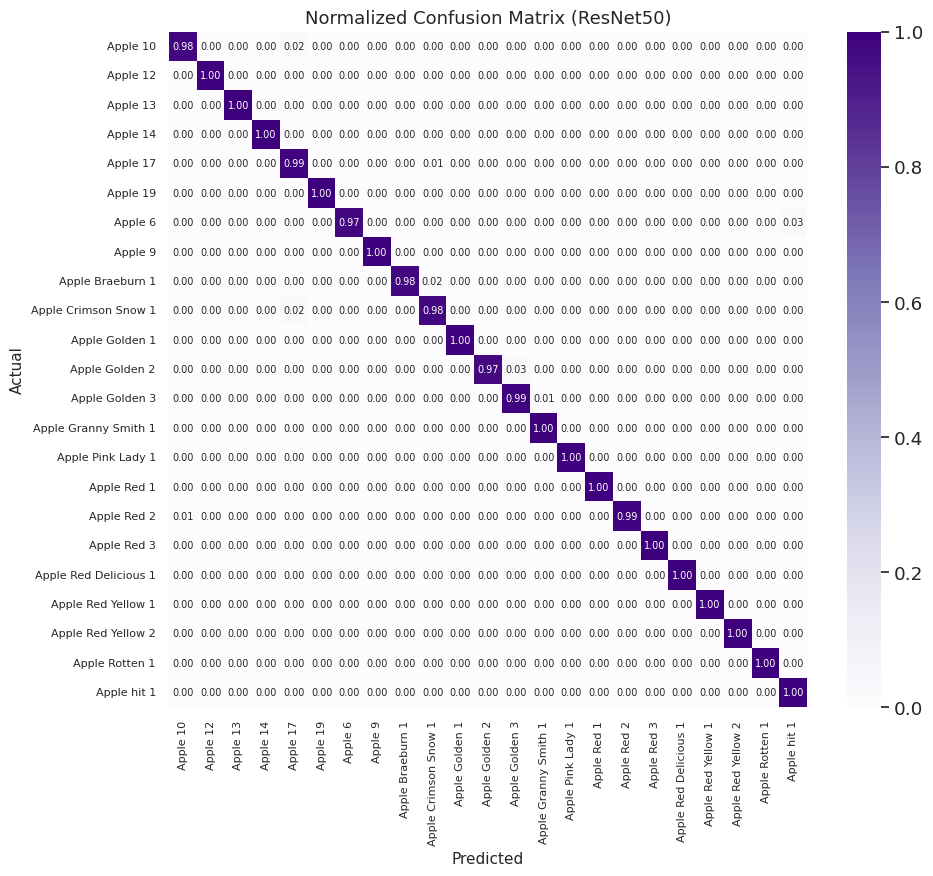

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Extract true and predicted labels from the validation dataset
resnet_true_labels = []
resnet_pred_labels = []

for batch_images, batch_labels in val_ds:
    predictions = resnet_model.predict(batch_images)
    predicted_classes = np.argmax(predictions, axis=1)

    resnet_true_labels.extend(batch_labels.numpy())
    resnet_pred_labels.extend(predicted_classes)

# 2. Compute normalized confusion matrix
cm_resnet = confusion_matrix(resnet_true_labels, resnet_pred_labels, normalize='true')

# 4. Plot the heatmap (smaller layout, consistent style)
plt.figure(figsize=(10, 9))
sns.heatmap(cm_resnet,
            annot=True,
            fmt=".2f",
            cmap="Purples",
            xticklabels=class_names,
            yticklabels=class_names,
            annot_kws={"size": 7})

plt.xlabel("Predicted", fontsize=11)
plt.ylabel("Actual", fontsize=11)
plt.title("Normalized Confusion Matrix (ResNet50)", fontsize=13)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/fruit_360/confusion_matrix_resnet_small.png', bbox_inches='tight', dpi=300)
plt.show()

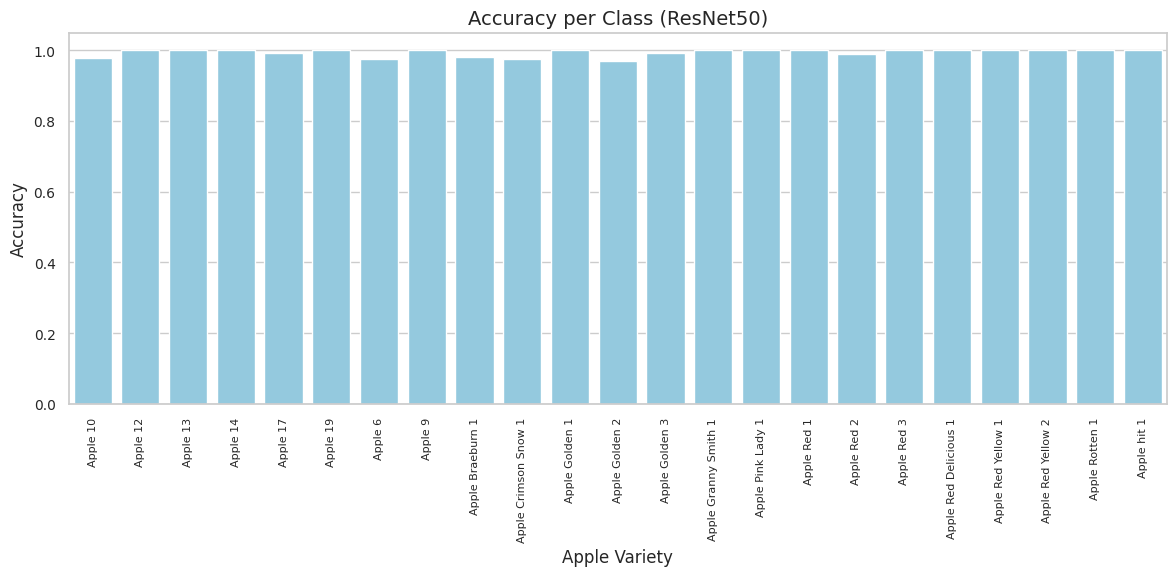

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert to NumPy arrays if not already
resnet_true_labels = np.array(resnet_true_labels)
resnet_pred_labels = np.array(resnet_pred_labels)

# Compute class-wise accuracy
class_accuracies_resnet = []
for i in range(len(class_names)):
    true_class_indices = (resnet_true_labels == i)
    correct_predictions = (resnet_pred_labels[true_class_indices] == i).sum()
    total_samples = true_class_indices.sum()
    accuracy = correct_predictions / total_samples if total_samples > 0 else 0
    class_accuracies_resnet.append(accuracy)

# Plot with a fixed color
plt.figure(figsize=(12, 6))
sns.barplot(x=class_names, y=class_accuracies_resnet, color="skyblue")  # Uniform color

plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=10)
plt.xlabel("Apple Variety", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy per Class (ResNet50)", fontsize=14)
plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/accuracy_per_class_resnet.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# True and predicted labels already collected using this:
resnet_true_labels = []
resnet_pred_labels = []

for batch_images, batch_labels in val_ds:
    predictions = resnet_model.predict(batch_images)
    predicted_classes = np.argmax(predictions, axis=1)

    resnet_true_labels.extend(batch_labels.numpy())
    resnet_pred_labels.extend(predicted_classes)

# Convert to numpy arrays
resnet_true_labels = np.array(resnet_true_labels)
resnet_pred_labels = np.array(resnet_pred_labels)

# Classification report
print("Classification Report (ResNet50)")
report = classification_report(resnet_true_labels, resnet_pred_labels, target_names=class_names, zero_division=0)
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/ste

In [ ]:
fig, ax = plt.subplots(figsize=(12, len(resnet_df)*0.4))
ax.axis('off')

table = ax.table(cellText=resnet_df.values,
                 colLabels=resnet_df.columns,
                 rowLabels=resnet_df.index,
                 cellLoc='center',
                 rowLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.2)

plt.savefig('/content/gdrive/MyDrive/resnet_classification_report.png', bbox_inches='tight', dpi=300)
plt.show()

<ipython-input-44-1a5ea81ef982>:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


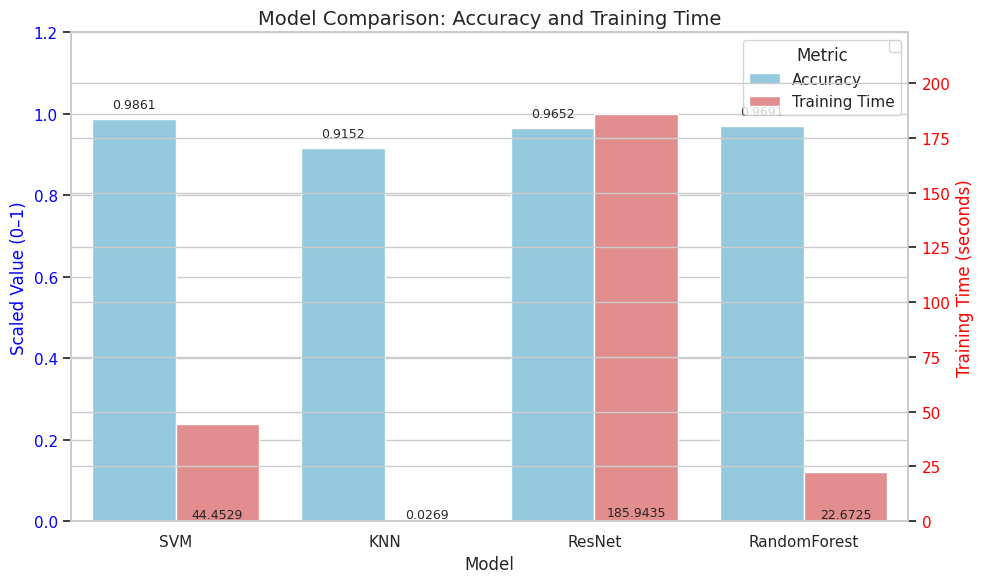

In [ ]:
time_resnet = 185.9435
resnet_accuracy = 0.9652

# === Model names and actual values ===
model_names = ['SVM', 'KNN', 'ResNet', 'RandomForest']
accuracies = [svm_accuracy, knn_accuracy, resnet_accuracy, rf_accuracy]
train_times = [svm_train_time, knn_train_time, time_resnet, rf_train_time]

# Normalize training times for left-axis scaling
max_time = max(train_times)
train_times_scaled = [t / max_time for t in train_times]

# === Create tidy DataFrame for Seaborn barplot
df = pd.DataFrame({
    'Model': model_names * 2,
    'Metric': ['Accuracy'] * len(model_names) + ['Training Time'] * len(model_names),
    'Value': accuracies + train_times_scaled,
    'Actual Time': [None] * len(model_names) + train_times  # Only relevant for training time bars
})

# === Plot with Seaborn on left axis
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barplot with Seaborn
barplot = sns.barplot(data=df, x='Model', y='Value', hue='Metric', palette=['skyblue', 'lightcoral'], ax=ax1)

# === Left y-axis config (Accuracy)
ax1.set_ylabel("Scaled Value (0–1)", color="blue")
ax1.set_ylim(0, 1.2)
ax1.tick_params(axis='y', labelcolor='blue')

# === Right y-axis config (Actual time values)
ax2 = ax1.twinx()
ax2.set_ylabel("Training Time (seconds)", color="red")
ax2.set_ylim(0, max_time * 1.2)
ax2.tick_params(axis='y', labelcolor='red')

# === Annotate all bars with real values
for bar, (_, row) in zip(barplot.patches, df.iterrows()):
    height = bar.get_height()
    label = row['Actual Time'] if row['Metric'] == 'Training Time' else row['Value']
    if label is not None:
        ax = ax2 if row['Metric'] == 'Training Time' else ax1
        ax.text(bar.get_x() + bar.get_width() / 2,
                height + 0.02,
                f'{label:.4f}',
                ha='center', va='bottom', fontsize=9)

# === Title and layout
plt.title('Model Comparison: Accuracy and Training Time', fontsize=14)
plt.legend()
plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/fruit_360/model_comparison.png', bbox_inches='tight')
plt.show()


In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(train_features)
y = np.array(train_labels)

# Regular K-Fold (not stratified)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# SVM model
#svm_model = SVC(kernel='linear', C=1.0, random_state=42)

# 5-fold CV
svm_scores = cross_val_score(model_svm, X_scaled, y, cv=kf, scoring='accuracy')
print("SVM 5-Fold Accuracies (Regular):", svm_scores)


SVM 5-Fold Accuracies (Regular): [1.         0.99826087 0.99913043 0.99913043 1.        ]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# KNN model
#knn_model = KNeighborsClassifier(n_neighbors=3)

# 5-fold CV
knn_scores = cross_val_score(model_knn, X_scaled, y, cv=kf, scoring='accuracy')
print("KNN 5-Fold Accuracies (Regular):", knn_scores)


KNN 5-Fold Accuracies (Regular): [0.99826087 0.99478261 0.99826087 0.99826087 1.        ]


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# 5-fold CV
rf_scores = cross_val_score(rf_model, X_scaled, y, cv=kf, scoring='accuracy')
print("Random Forest 5-Fold Accuracies (Regular):", rf_scores)


Random Forest 5-Fold Accuracies (Regular): [0.99826087 0.99913043 0.99913043 0.99913043 1.        ]


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from tensorflow.keras.applications.resnet import preprocess_input

# Step 1: Extract raw image arrays and labels from train_ds
X_resnet, y_resnet = [], []

for images, labels in train_ds:
    X_resnet.append(images.numpy())
    y_resnet.append(labels.numpy())

X_resnet = np.concatenate(X_resnet, axis=0)
y_resnet = np.concatenate(y_resnet, axis=0)

# Step 2: Preprocess input
X_resnet = preprocess_input(X_resnet * 255.0)

# Step 3: 5-fold cross-validation using resnet_model (already trained)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
resnet_scores = []

for train_idx, val_idx in kf.split(X_resnet, y_resnet):
    X_val = X_resnet[val_idx]
    y_val = y_resnet[val_idx]

    # ✅ FIX: force inference mode (disable dropout/batchnorm randomness)
    preds = resnet_model(X_val, training=False).numpy()
    pred_labels = np.argmax(preds, axis=1)

    acc = accuracy_score(y_val, pred_labels)
    resnet_scores.append(acc)

print("✅ Fixed ResNet50 5-Fold CV Accuracies:", resnet_scores)


ResourceExhaustedError: Exception encountered when calling Pad.call().

[1m{{function_node __wrapped__Pad_device_/job:localhost/replica:0/task:0/device:GPU:0}} OOM when allocating tensor with shape[1989,106,106,3] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Pad] name: [0m

Arguments received by Pad.call():
  • x=tf.Tensor(shape=(1989, 100, 100, 3), dtype=float32)
  • constant_values=None

In [ ]:
svm_scores = svm_scores.mean()
knn_scores = knn_scores.mean()
rf_scores = rf_scores.mean()
resnet_scores = np.array(resnet_scores).mean()
svm_scores, knn_scores, rf_scores, resnet_scores

<ipython-input-125-815f9010288e>:4: RuntimeWarning: Mean of empty slice.
  resnet_scores = np.array(resnet_scores).mean()
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(np.float64(0.9993043478260869),
 np.float64(0.9979130434782608),
 np.float64(0.9991304347826088),
 np.float64(nan))

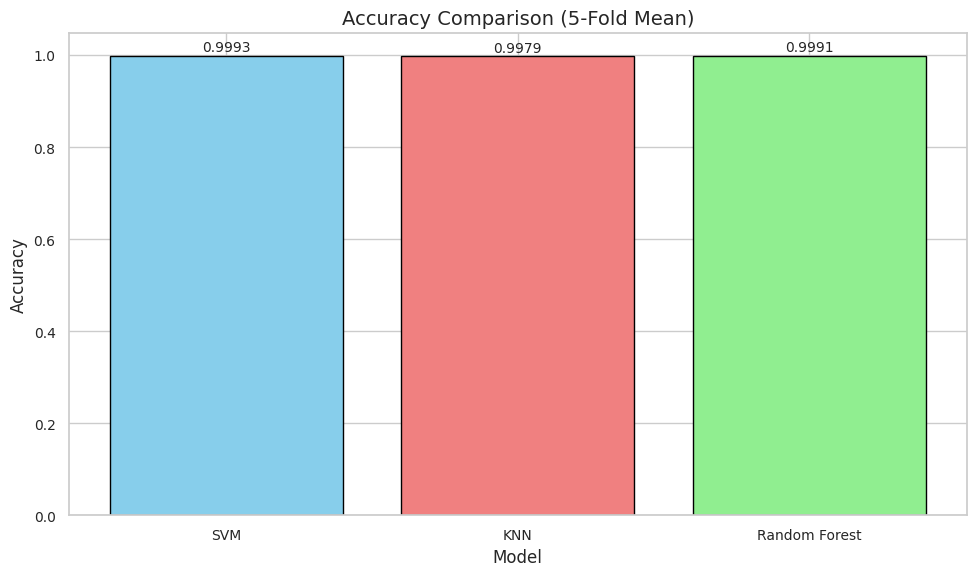

In [ ]:
model_class = ['SVM', 'KNN', 'Random Forest']
accuracy_scores = [svm_scores, knn_scores, rf_scores]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_class, accuracy_scores, color=['skyblue', 'lightcoral', 'lightgreen'], edgecolor='black')

plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.title('Accuracy Comparison (5-Fold Mean)', fontsize=14)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)

# Annotate each bar with the value
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0,
             height + 0.002,  # small space above bar
             f'{height:.4f}',  # format to 4 decimal places
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/accuracy_comparison_cross_val.png', bbox_inches='tight')
plt.show()

In [ ]:
img = Image.open('/content/gdrive/MyDrive/fruit_360/multi_obj_output.png')

img_resized = img.resize((60, 60))
img_rgb = img_resized.convert('RGB')
img_array = np.array(img_rgb).flatten()

img_array = img_array.reshape(1, -1)

svm_pred = model_svm.predict(img_array)
knn_pred = model_knn.predict(img_array)
rf_pred = model_rf.predict(img_array)


print(f"SVM predicted class: {svm_pred}")
print(f"KNN predicted class: {knn_pred}")
print(f"Random Forest predicted class: {rf_pred}")

SVM predicted class: ['Apple 17']
KNN predicted class: ['Apple 17']
Random Forest predicted class: ['Apple Braeburn 1']
